In [1]:
#2021.06.30. WED
#Hankyeong

#00. 패키지 호출
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

#00-1. 씨드넘버 설정하기. 
np.random.seed(2021)
tf.random.set_seed(2021)

#00-2. 시각화 옵션 설정하기. 
%matplotlib inline 

In [2]:
#07. cifar10 데이터셋 전처리하기. 
#(1) 데이터셋 불러오기 및 분할하기. 
(X_train, y_train), (X_test,y_test) = cifar10.load_data()

In [3]:
#(2) train, test 데이터셋 차원 확인하기. 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

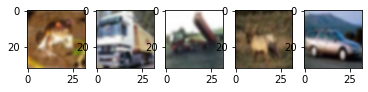

In [4]:
#(3) X_train의 첫 5개 표본 사진 확인하기. 
plt.subplot(151)
plt.imshow(X_train[0], interpolation='bicubic')
plt.subplot(152)
plt.imshow(X_train[1], interpolation='bicubic')
plt.subplot(153)
plt.imshow(X_train[2], interpolation='bicubic')
plt.subplot(154)
plt.imshow(X_train[3], interpolation='bicubic')
plt.subplot(155)
plt.imshow(X_train[4], interpolation='bicubic')
plt.show()

In [5]:
#(4) X_train의 첫 5개 표본의 target 값 확인하기. 
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
class_names[y_train[0][0]],class_names[y_train[1][0]],class_names[y_train[2][0]],class_names[y_train[3][0]], class_names[y_train[4][0]]

('frog', 'truck', 'truck', 'deer', 'automobile')

In [6]:
#(5) 3차원 데이터셋을 2차원으로 변환하기. 
X_train = X_train.reshape(-1,1024)
X_test = X_test.reshape(-1,1024)

#(6) feature 데이터 스케일링 처리하기. 
X_train_mm = MinMaxScaler().fit_transform(X_train)
X_test_mm = MinMaxScaler().fit_transform(X_test)

#(7) target 데이터 원핫인코딩 처리하기. 
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

#(8) 형태 재설정하기. 
X_train = X_train_mm.reshape(-1,32,32,3)
X_test = X_test_mm.reshape(-1,32,32,3)

#(9) train, test 데이터셋 차원 재확인하기. 
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [7]:
#08. CNN 모델 정의, 컴파일 설정, 학습, 평가하기. 
#(1) 정의 전 상수 설정하기. 
NUM_CLASSES = 10 
EPOCHS = 100 
BATCH_SIZE = 32 
NUM_PREDICTIONS = 20 
MODEL_PATH = '../../model/cifar_best_CNN_model.h5'

#(2) 모델 정의하기. 
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(32,32,3), activation='relu'),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(rate=0.25),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(rate=0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.5),
    Dense(NUM_CLASSES, activation='softmax')    
])

#(3) 모델 요약 정보 확인하기. 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [8]:
#(4) optimizer 설정하기. 
optimizer = RMSprop(learning_rate=0.0001, decay=1e-6)

#(5) compiler 설정하기. 
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics='accuracy'
)

#(6) checkpointer 객체 정의하기. 
checkpointer = ModelCheckpoint(
    filepath = MODEL_PATH,
    monitor  = 'val_loss',
    save_best_only = True,
    verbose = 0
)

#(7) earlystopping 객체 할당하기. 
earlystopping = EarlyStopping(patience=15)

#(8) 모델 학습하기. 
model_fit = model.fit(
    X_train, Y_train, 
    validation_split = 0.2,
    epochs           = EPOCHS,
    shuffle          = True,
    callbacks        = [checkpointer, earlystopping],
    verbose=0
)

#(9) best 모델 할당하기. 
best_model = load_model(MODEL_PATH)

#(10) 모델 예측 및 평가하기. 
accuracy_score = best_model.evaluate(X_test, Y_test)
accuracy_score

313/313 [==============================] - 1s 3ms/step - loss: 0.6815 - accuracy: 0.7736


[0.6814756989479065, 0.7735999822616577]

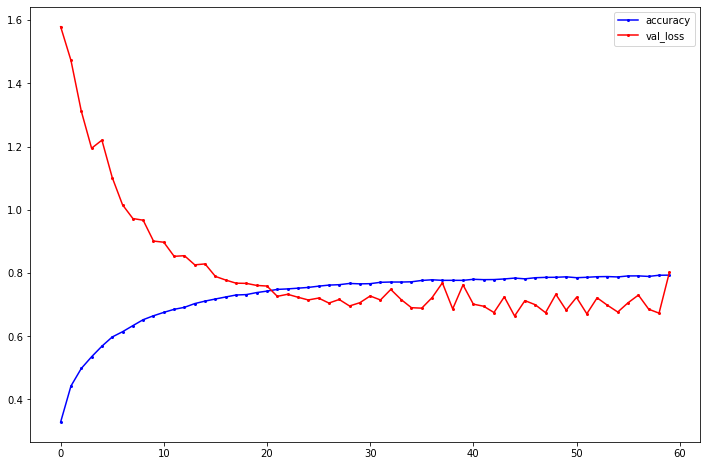

In [9]:
#(11) 학습과정 시각화하기. 
y_vloss = model_fit.history['val_loss']
y_accuracy = model_fit.history['accuracy']
x_len = np.arange(len(y_vloss))
plt.figure(figsize=(12,8))
plt.plot(x_len, y_accuracy, 'bo-', markersize=2, label='accuracy')
plt.plot(x_len, y_vloss, 'ro-', markersize=2, label='val_loss')
plt.legend()
plt.show()